In [73]:
import torch, math,os, glob, random
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data Prerocessing

In [74]:
## construct images and labels

def process_img(folder ):
    matrix_all = []
    label_all =[]
    imgs = glob.glob('%s/*.jpg'%folder)
    labels = glob.glob('%s/*.att'%folder)
    
    # read images
    for img in imgs:
        image = cv.imread(img)
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        gray_matrix = np.array(gray_image)
        
        matrix_all.append(gray_matrix)
        
    # read labels
    for label in labels:
        with open(label, 'r') as file:
            for idx, line in enumerate(file):
                if idx ==1:
                    #print(line)
                    single_label = line.split('.')[0]
                    label_all.append(int(single_label))
    return matrix_all, label_all

### shape of data: trainset:1000, testset:250
train_X,train_Y = process_img('TrainImages')
test_X, test_Y = process_img('TestImages')
## few matrixs are in shape 102, which should be deleted
for flag, single_set in enumerate([train_X, test_X]):
    for idx, mtx in enumerate(single_set):
        # delete the last column and row
        if mtx.shape[0] == 102 or mtx.shape[1] == 102:
            mtx = mtx[:-1, :-1]
            # substitute original matrix to new one
            if flag == 0:
                train_X[idx] = mtx
                #del train_x[idx]
                #del train_y[idx]
                
            elif flag ==1:
                test_X[idx] = mtx
                #del test_x[idx]
                #del test_y[idx]                
# type( train_x[1] ), test_x[2].shape,  test_x[2] len(train_y) ,train_y[2], len(test_x)


train_X = [ele.reshape(1,-1) for ele in train_X]
test_X = [ele.reshape(1,-1) for ele in test_X]
train_X = np.vstack(train_X)   ## 1000 * 10201
test_X = np.vstack(test_X)   # 250*10201

# standardize data 
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

# (1). Label Distribution

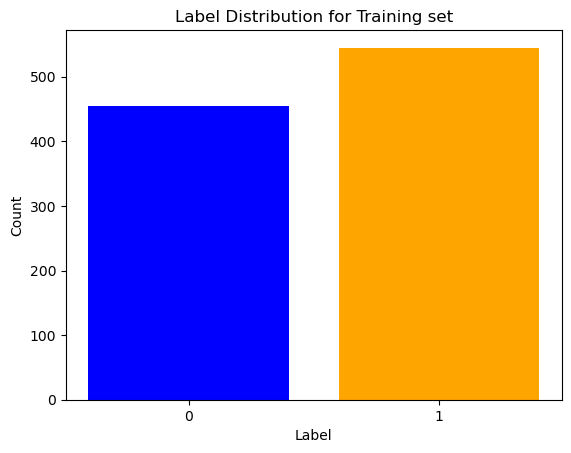

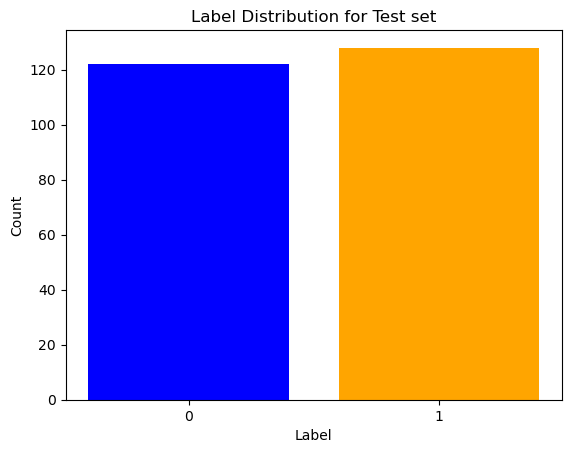

In [75]:
for label_dist, set_name in zip([train_Y, test_Y],['Training set','Test set']):
    unique_labels, label_counts = np.unique(label_dist, return_counts=True)
    plt.figure(   )
    # 创建直方图
    plt.bar(unique_labels, label_counts, tick_label=unique_labels, color=['blue', 'orange'])

    # 设置图表标题和轴标签
    plt.title('Label Distribution for %s'%set_name)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# (2). Single Layer Perceptron

Apply Rosenblatt’s perceptron (single layer perceptron) to your assigned task. 
After the training procedure, calculate the classification accuracy for both the 
training set and test set, and evaluate the performance of the perceptron

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # input layer to output layer ,linear connect

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))  # relu activation function
        #print(x)
        return x


def SLP_model(train_x, test_x, train_y, test_y):
    #  train_X_tensor should be in shape 1000*10201
    train_X_tensor = torch.tensor(train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    test_X_tensor = torch.tensor(test_x, dtype=torch.float32)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

    input_size = train_x.shape[1]
    perceptron = Perceptron(input_size)

    criterion = nn.MSELoss()  # 二元交叉熵损失函数
    optimizer = optim.Adam(perceptron.parameters(), lr=0.001)

    # training model 
    num_epochs = 1000
    for epoch in range(num_epochs):
        # feedforward
        outputs = perceptron(train_X_tensor)
        #print(outputs[:5])
        loss = criterion(outputs, train_y_tensor.unsqueeze(1))  #  train_y_tensor.unsqueeze(1) add one dim

        # BP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    # 在训练集和测试集上评估模型
    with torch.no_grad():
        train_outputs = (perceptron(train_X_tensor) > 0.5).float()
        #print(train_outputs)
        train_accuracy = (train_outputs == train_y_tensor.unsqueeze(1)).float().mean().item()
        print("Training set accuracy:", train_accuracy)

        test_outputs = (perceptron(test_X_tensor) > 0.5).float()
        test_accuracy = (test_outputs == test_y_tensor.unsqueeze(1)).float().mean().item()
        print("Test set accuracy:", test_accuracy)
    
    return train_accuracy, test_accuracy



In [25]:
## without PCA
SLP_model(train_X, test_X, train_Y, test_Y)

Epoch [100/1000], Loss: 0.0384
Epoch [200/1000], Loss: 0.0214
Epoch [300/1000], Loss: 0.0169
Epoch [400/1000], Loss: 0.0152
Epoch [500/1000], Loss: 0.0137
Epoch [600/1000], Loss: 0.0132
Epoch [700/1000], Loss: 0.0129
Epoch [800/1000], Loss: 0.0127
Epoch [900/1000], Loss: 0.0126
Epoch [1000/1000], Loss: 0.0125
Training set accuracy: 0.9879999756813049
Test set accuracy: 0.7799999713897705


(0.9879999756813049, 0.7799999713897705)

# (3). PCA 

The original input dimension is 10,201 (101*101), which may be redundant and 
leave space for reduction. Try to naively downsample the images or apply a 
more sophisticated technique like PCA to these images. Then, retrain the
perceptron in b) with the dimensionally reduced images and compare the results.

Epoch [100/1000], Loss: 0.4947
Epoch [200/1000], Loss: 0.4845
Epoch [300/1000], Loss: 0.2503
Epoch [400/1000], Loss: 0.2460
Epoch [500/1000], Loss: 0.2460
Epoch [600/1000], Loss: 0.2460
Epoch [700/1000], Loss: 0.2460
Epoch [800/1000], Loss: 0.2460
Epoch [900/1000], Loss: 0.2460
Epoch [1000/1000], Loss: 0.2460
Training set accuracy: 0.5419999957084656
Test set accuracy: 0.46399998664855957
Epoch [100/1000], Loss: 0.3858
Epoch [200/1000], Loss: 0.3725
Epoch [300/1000], Loss: 0.3432
Epoch [400/1000], Loss: 0.2350
Epoch [500/1000], Loss: 0.2331
Epoch [600/1000], Loss: 0.2329
Epoch [700/1000], Loss: 0.2329
Epoch [800/1000], Loss: 0.2329
Epoch [900/1000], Loss: 0.2329
Epoch [1000/1000], Loss: 0.2329
Training set accuracy: 0.6119999885559082
Test set accuracy: 0.5360000133514404
Epoch [100/1000], Loss: 0.3106
Epoch [200/1000], Loss: 0.1895
Epoch [300/1000], Loss: 0.1678
Epoch [400/1000], Loss: 0.1628
Epoch [500/1000], Loss: 0.1606
Epoch [600/1000], Loss: 0.1601
Epoch [700/1000], Loss: 0.1601


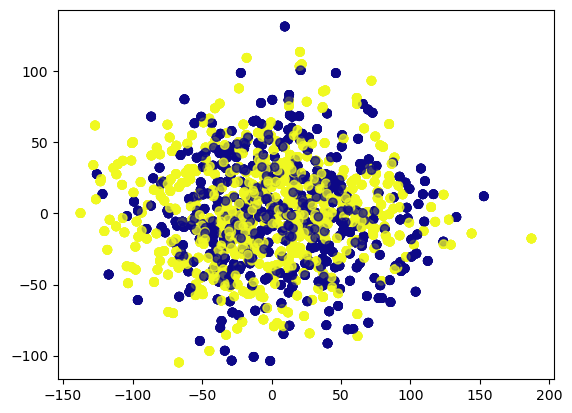

In [31]:
def pca(train_X, test_X, n):
    #scaler = StandardScaler()
    #train_x_st = scaler.fit_transform(np.array(train_X).reshape(1000,10201) ) # 1000*10201
    #test_x_st = scaler.fit_transform(np.array(test_X).reshape(250,10201))

    pca = PCA(n_components=n)  # 降到2维
    train_pca1 = pca.fit_transform(train_X)  # .reshape(1000,10201)
    test_pca1 = pca.fit_transform(test_X)  # .reshape(250,10201)
    plt.scatter(train_pca1[:, 0], train_pca1[:, 1], c=train_Y,cmap = 'plasma',alpha = 0.7)
    return train_pca1, test_pca1

train_n_accu = []
test_n_accu = []
for n in[2,8,15,18,20,23,25,30,40]:
    train_pca, test_pca = pca(train_X, test_X , n)
    train_acc, test_acc = SLP_model(train_pca, test_pca, train_Y, test_Y)
    train_n_accu.append(train_acc)
    test_n_accu.append(test_acc)


Text(0, 0.5, 'Accuracy')

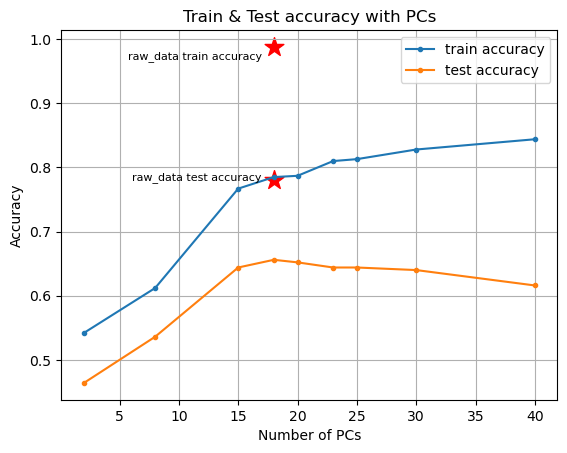

In [48]:
plt.scatter([18,18], [0.988, 0.78], color='red', marker='*', s=200)
plt.text(17, 0.97, "raw_data train accuracy", fontsize=8, ha='right')
plt.text(17, 0.78, "raw_data test accuracy", fontsize=8, ha='right')

plt.plot([2,8,15,18,20,23,25,30,40],train_n_accu,marker ='.', label = 'train accuracy')
plt.plot([2,8,15,18,20,23,25,30,40],test_n_accu , marker ='.' , label ='test accuracy')

plt.legend(loc ='best')
plt.grid()
plt.title('Train & Test accuracy with PCs')
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')

In [11]:
#  # standardize data
#  scaler = StandardScaler()
#  train_x_st = scaler.fit_transform(np.array(train_X).reshape(1000,10201) ) # 1000*10201
#  test_x_st = scaler.fit_transform(np.array(test_X).reshape(250,10201))
#  
#  # covariance matrix
#  cov_matrix = (train_x_st.T @ train_x_st) / (train_x_st.shape[0] - 1)  # 10201*10201
#  
#  # 3 SVD
#  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)  # ndarray 
#  
#  n_components = 2
#  principal_components = eigenvectors[:, -n_components:]  # 10201*5
#  train_X_projected = train_x_st @ principal_components  # 1000*5
#  test_X_projected = test_x_st @ principal_components
#  plt.scatter(train_X_projected[:,0], train_X_projected[:,1], c=train_Y, cmap='viridis',alpha = 0.5)
#  plt.title('PCA of Training set ')
#  
#  ## single layer model with PCA
#  training_model(train_X_projected, test_X_projected, train_Y, test_Y)

# (4). MLP with batch training

Apply MLP to your assigned task using batch mode training. After the training 
procedure, calculate the classification accuracy for both the training set and test
set, and evaluate the performance of the network.

In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(18, 256)
        #self.fc2 = nn.Linear(100,64)
        self.fc3 = nn.Linear(256,32)
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        #self.relu = torch.relu()

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        x = torch.tanh (self.fc3(x))
        x = torch.tanh ( self.fc4(x) )
        return x

def MLP_batch_model(train_x, test_x, train_y, test_y):
    train_X_tensor = torch.tensor(train_x, dtype=torch.float32)

    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    #print(train_y_tensor.shape)
    test_X_tensor = torch.tensor(test_x, dtype=torch.float32)

    test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

    model = MLP()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    #print(train_X_tensor.shape)
    
    num_epochs = 100
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(  outputs.squeeze(), train_y_tensor  ) #  outputs, train_y_tensor.unsqueeze(1)
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    # Step 5: Evaluate the performance of your model
    with torch.no_grad():
        # Evaluate on training set
        train_outputs = model(train_X_tensor)
        #print(train_outputs[:45])
        train_predictions = (train_outputs >= 0).float()
        #print(train_predictions_1[:5])
        train_accuracy = (train_predictions == train_y_tensor.unsqueeze(1)).float().mean()

        # Evaluate on test set
        test_outputs = model(test_X_tensor)
        test_predictions = (test_outputs >= 0).float()
        test_accuracy = (test_predictions == test_y_tensor.unsqueeze(1)).float().mean()

    print(f'Training Accuracy: {train_accuracy.item()*100:.2f}%')
    print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')    
    return train_outputs



In [117]:
train_outputs = MLP_batch_model(train_X, test_X, train_Y, test_Y)

Epoch [100/100], Loss: 0.2518
Training Accuracy: 54.50%
Test Accuracy: 51.20%


AttributeError: 'list' object has no attribute 'shape'

Epoch [100/100], Loss: 0.2603
Training Accuracy: 54.50%
Test Accuracy: 51.20%


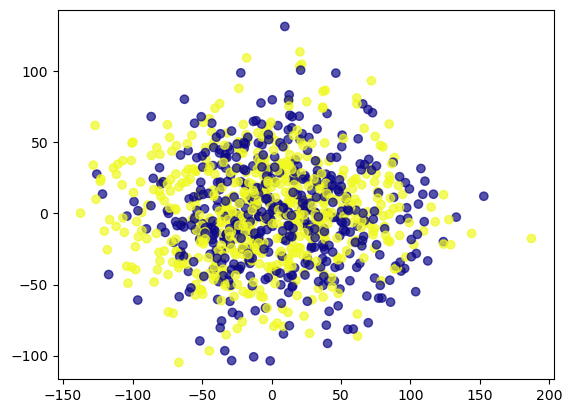

In [127]:
train_pca_18, test_pca_18 = pca(train_X, test_X , 18)
PCA_outputs =MLP_batch_model(train_pca_18, test_pca_18, train_Y, test_Y)

# (5). MLP with sequential training

In [128]:
def MLP_sequential_model(train_x, test_x, train_y, test_y):
    train_X_tensor = torch.tensor(train_x, dtype=torch.float32)

    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    train_y_tensor = train_y_tensor.unsqueeze(1)
    test_X_tensor = torch.tensor(test_x, dtype=torch.float32)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32)
    test_y_tensor = test_y_tensor.unsqueeze(1)
    
    model = MLP()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    #print(len(train_X_tensor[2]), (train_y_tensor[2]))
    
    num_epochs = 100
    for epoch in range(num_epochs):
        for i in range(len(train_X_tensor)):
            inputs = train_X_tensor[i]
            labels = train_y_tensor[i]

            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

    # Step 5: Evaluate the performance of your model
    with torch.no_grad():
        # Evaluate on training set
        train_outputs = model(train_X_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = (train_predictions == train_y_tensor).float().mean()

        # Evaluate on test set
        test_outputs = model(test_X_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        test_accuracy = (test_predictions == test_y_tensor).float().mean()

    print(f'Training Accuracy: {train_accuracy.item()*100:.2f}%')
    print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')    
    return 

In [129]:
MLP_sequential_model(train_pca_18, test_pca_18, train_Y, test_Y)

18 tensor([0.])
Training Accuracy: 78.70%
Test Accuracy: 65.60%


#### Comment: 

Train&test accuracy of sequential learning is better than batch learning. Batch leanring takes less training time than sequential learning. 

Sequential learning updates weights each step while batch learning do so each epoch by the average value of weights. It indicates that weights iteration of sequential learning is more accurate than batch learning, but the iteration time is epoch * Number of inputs

# (6). Placing eyes
You may notice that all the images, either for training or test, are already aligned 
by placing eyes at a certain location. Do you think it is necessary to do so? 
Justify your answer.

### It is not necessary as long as whole face is in the image

In [67]:
## construct images and labels
import random
def rotate_img(folder ):
    matrix_all = []
    label_all =[]
    imgs = glob.glob('%s/*.jpg'%folder)
    labels = glob.glob('%s/*.att'%folder)
    
    # read images
    for img in imgs:
        flag = random.randint(0, 3)
        image = cv.imread(img)
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        gray_matrix = np.array(gray_image)
        
        if flag ==1:  # anti-clockwise 90
            gray_matrix = np.rot90(gray_matrix)
        elif flag ==2:  # clockwise 90
            gray_matrix = np.rot90(gray_matrix , k=-1)
        elif flag ==3: # 180 degrees
            gray_matrix = np.rot90(gray_matrix , k=2)
        
        matrix_all.append(gray_matrix)
        
    # read labels
    for label in labels:
        with open(label, 'r') as file:
            for idx, line in enumerate(file):
                if idx ==1:
                    #print(line)
                    single_label = line.split('.')[0]
                    label_all.append(int(single_label))
    return matrix_all, label_all


In [68]:
### shape of data: trainset:1000, testset:250
train_X_uncenter,train_Y_uncenter = rotate_img('TrainImages')
test_X_uncenter, test_Y_uncenter = rotate_img('TestImages')
## few matrixs are in shape 102, which should be deleted
for flag, single_set in enumerate([train_X_uncenter, test_X_uncenter]):
    for idx, mtx in enumerate(single_set):
        # delete the last column and row
        if mtx.shape[0] == 102 or mtx.shape[1] == 102:
            mtx = mtx[:-1, :-1]
            # substitute original matrix to new one
            if flag == 0:
                train_X_uncenter[idx] = mtx
                #del train_x[idx]
                #del train_y[idx]
                
            elif flag ==1:
                test_X_uncenter[idx] = mtx
                #del test_x[idx]
                #del test_y[idx]                

train_X_uncenter = [ele.reshape(1,-1) for ele in train_X]
test_X_uncenter = [ele.reshape(1,-1) for ele in test_X]
train_X_uncenter = np.vstack(train_X)   ## 1000 * 10201
test_X_uncenter = np.vstack(test_X)   # 250*10201
# standardize data 
scaler = StandardScaler()
train_X_uncenter = scaler.fit_transform(train_X_uncenter)
test_X_uncenter = scaler.fit_transform(test_X_uncenter)

In [70]:
MLP_batch_model(train_X_uncenter, test_X_uncenter, train_Y_uncenter, test_Y_uncenter)

Epoch [100/1000], Loss: 0.2477
Epoch [200/1000], Loss: 0.2476
Epoch [300/1000], Loss: 0.2480
Epoch [400/1000], Loss: 0.2484
Epoch [500/1000], Loss: 0.2483
Epoch [600/1000], Loss: 0.2487
Epoch [700/1000], Loss: 0.2485
Epoch [800/1000], Loss: 0.2486
Epoch [900/1000], Loss: 0.2484
Epoch [1000/1000], Loss: 0.2476
Training Accuracy: 54.50%
Test Accuracy: 51.20%


Epoch [100/1000], Loss: 0.2083
Epoch [200/1000], Loss: 0.1676
Epoch [300/1000], Loss: 0.1577
Epoch [400/1000], Loss: 0.1536
Epoch [500/1000], Loss: 0.1530
Epoch [600/1000], Loss: 0.1529
Epoch [700/1000], Loss: 0.1529
Epoch [800/1000], Loss: 0.1529
Epoch [900/1000], Loss: 0.1529
Epoch [1000/1000], Loss: 0.1529
Training set accuracy: 0.7829999923706055
Test set accuracy: 0.6520000100135803


(0.7829999923706055, 0.6520000100135803)

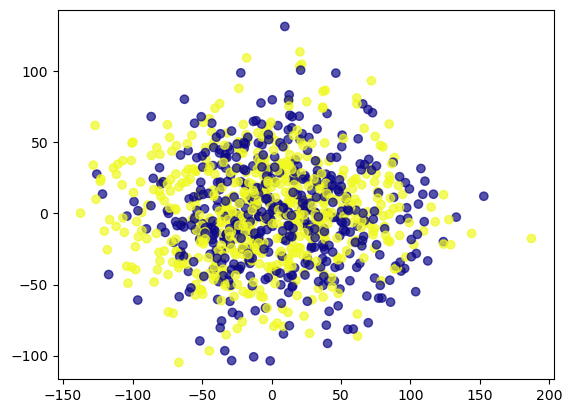

In [72]:
train_pca_un, test_pca_un = pca(train_X_uncenter, test_X_uncenter,18)
SLP_model(train_pca_un, test_pca_un, train_Y_uncenter, test_Y_uncenter)